# Multimodal Financial Research Agent with Hybrid Search
Build an intelligent agent that can search financial documents (RAG) and live market data to provide comprehensive insights.

## Overview

This notebook covers:
- **Hybrid Search (RAG)**: Semantic + keyword search with automatic filter extraction from historical SEC filings
- **Live Finance Research**: Real-time stock data and market information via Yahoo Finance MCP
- **Agent with Dual Tools**: Connect LLM agent with both vector database and live APIs
- **Financial Analysis**: Query historical SEC filings (10-K, 10-Q) and current market data
- **Metadata Filtering**: Automatic extraction of company, year, quarter from queries

## Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

from langchain.agents import create_agent

from langchain.messages import HumanMessage, ToolMessage, AIMessage, SystemMessage
from langchain_core.tools import tool

from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3

from scripts.rag_tools import hybrid_search


In [4]:
results = hybrid_search.invoke({'query': 'what is the revenue of apple in 2024'})

In [5]:
results

[Document(metadata={'company_name': 'apple', 'doc_type': '10-q', 'fiscal_quarter': 'q1', 'fiscal_year': '2024', 'content_type': 'text', 'file_hash': 'ac42f4e54579f8ce7c3775fc114501de8c74d081e4e64319725df838cac920cd', 'source_file': 'apple 10-q q1 2024.md', 'page': 9, '_id': '9c94a262-76a8-4490-88e6-de5e73bf2a62', '_collection_name': 'financial_docs'}, page_content="\n\n## Apple Inc.\n\n## Notes to Condensed Consolidated Financial Statements (Unaudited)\n\n## Note 1 - Summary of Significant Accounting Policies\n\n## Basis of Presentation and Preparation\n\nThe condensed consolidated financial statements include the accounts of Apple Inc. and its wholly owned subsidiaries (collectively 'Apple' or the 'Company'). In the opinion of the Company's management, the condensed consolidated financial statements reflect all adjustments, which are normal and recurring in nature, necessary for fair financial statement presentation. The preparation of these condensed consolidated financial statements

In [6]:
from scripts.prompts import MULTIMODEL_AGENT_PROMPT

# Initialize the model
# You can use any available model at google ai studio
model = ChatGoogleGenerativeAI(model='gemini-3-flash-preview')

## Define Live Finance Research Tool

In [7]:
import subprocess
import sys

@tool
def live_finance_researcher(query: str):
    """
    Research live stock data using Yahoo Finance MCP.
    
    Use this tool to get:
    - Current stock prices and real-time market data
    - Latest financial news
    - Stock recommendations and analyst ratings
    - Option chains and expiration dates
    - Recent stock actions (splits, dividends)
    
    Args:
        query: The financial research question about current market data
        
    Returns:
        Research results from Yahoo Finance
    """

    code = f"""
import asyncio
from scripts.yahoo_mcp import finance_research
asyncio.run(finance_research("{query}"))
"""
    result = subprocess.run([sys.executable, '-c', code], capture_output=True, text=True)

    return result.stdout

In [8]:
live_finance_researcher.invoke({'query': 'what is the latest stock price of Apple'})

'The latest stock price of Apple (AAPL) is $271.84.\n'

## Create Financial Research Agent with Memory

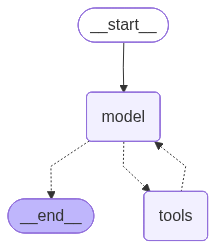

In [9]:
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3
from langchain.agents import create_agent

def get_agent():
    conn = sqlite3.connect('data/financial_research_agent.db', check_same_thread=False)
    checkpointer = SqliteSaver(conn=conn)

    agent = create_agent(
        model=model,
        tools=[hybrid_search, live_finance_researcher],
        system_prompt=MULTIMODEL_AGENT_PROMPT,
        checkpointer=checkpointer
    )

    return agent

agent = get_agent()

agent

In [10]:
config = {'configurable': {'thread_id': 'session1'}}

query = 'What is the apples cash flow in 2023?'

agent = get_agent()
response = agent.invoke({'messages': [HumanMessage(query)]}, config=config)

In [11]:
response

{'messages': [HumanMessage(content='What is the apples cash flow in 2023?', additional_kwargs={}, response_metadata={}, id='23840a55-6add-4f80-874b-c137bf7c680c'),
  AIMessage(content=[], additional_kwargs={'function_call': {'name': 'hybrid_search', 'arguments': '{"query": "Apple cash flow 2023 10-K"}'}, '__gemini_function_call_thought_signatures__': {'66532db2-4ac5-4f40-aa30-12d704526dfa': 'EsICCr8CAXLI2nw1+9HR7iqA823v8rBjhoc1y75zYiKSC/AlmnRgNaloObnCQaFN9oijGLelpHBzbqWG3nBA1yg32SHavIJ8Ngs3IoFJHUr/GuSgUOm6FIy/u9tVIITlMR11WdhHWOeQumtkuDUOPifK68G9qcBSh7rFETdbETzRJibzL2/Fykr4lHP4MRSSScCw5bC/M9Nb8Rgdemo9zoTkz4GivbSlEer0w0VVUc9b2Ei35ix/bvTziofME44Ndf2631a1PfZJLGZ3V0gNi6geWPi4kXrvZMK6+8g7gb5Q26W3cMqLa2IXpUcerLfsgKk3D2R7BtjYfJ1BNIYh0EaZZwvCph2CAgbMYNlZ/33V+sZkkaDJG7q0Sr9wACykl4z/HVi5aXJ3mo3o/wc6wu+p/Hf2jxQxYskPmm0r3Lh2reG4qQ=='}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-3-flash-preview', 'safety_ratings': 

In [12]:
print(response['messages'][-1].text)

For the fiscal year ended September 30, 2023, Apple Inc. reported a strong cash flow position. Below is the detailed breakdown from their Consolidated Statement of Cash Flows:

### **Cash Flow Summary (Fiscal Year 2023)**
| Metric | Amount (in millions) |
| :--- | :--- |
| **Net Income** | **$96,995** |
| **Cash Generated by Operating Activities** | **$110,543** |
| **Cash Generated by Investing Activities** | **$3,705** |
| **Cash Used in Financing Activities** | **($108,488)** |
| **Net Increase in Cash & Equivalents** | **$5,760** |

### **Key Financial Highlights**
*   **Operating Cash Flow:** At $110.5 billion, Apple’s ability to generate cash from its core business remains massive. Major non-cash adjustments included **$11.5 billion** in depreciation/amortization and **$10.8 billion** in share-based compensation.
*   **Free Cash Flow (FCF):** While not explicitly a line item, FCF is typically calculated as Operating Cash Flow minus Capital Expenditures.
    *   *Calculation:* $11

## Streaming Helper Function

In [ ]:
def stream_agent_response(agent, query, thread_id="default"):

    config = {'configurable': {'thread_id': thread_id}}
    
    for chunk in agent.stream(
        {'messages': [HumanMessage(query)]},
        stream_mode='messages',
        config=config
    ):
        # Extract message from chunk
        message = chunk[0] if isinstance(chunk, tuple) else chunk
        
        # Handle AI messages with tool calls
        if isinstance(message, AIMessage) and message.tool_calls:
            for tool_call in message.tool_calls:
                print(f"\n  Tool Called: {tool_call['name']}")
                print(f"   Args: {tool_call['args']}")
                print()
        
        # Handle tool responses
        elif isinstance(message, ToolMessage):
            print(f"\n  Tool Result (length: {len(message.text)} chars)")
            print()
        
        # Handle AI text responses
        elif isinstance(message, AIMessage) and message.text:
            # Stream the text content
            print(message.text, end='', flush=True)

## Examples

In [15]:
query = 'What is the apples cash flow in 2023?'
agent = get_agent()

stream_agent_response(agent, query, 'session2')


  Tool Called: hybrid_search
   Args: {'query': "Apple's cash flow in fiscal year 2023"}


  Tool Result (length: 22940 chars)

For the fiscal year ended September 30, 2023, Apple's cash flow details (in millions) were as follows:

| Cash Flow Category | Fiscal Year 2023 (In millions) |
| :--- | :--- |
| **Cash generated by operating activities** | **$110,543** |
| **Cash generated by investing activities** | **$3,705** |
| **Cash used in financing activities** | **($108,488)** |
| **Net increase in cash, cash equivalents, and restricted cash** | **$5,760** |

### Key Details from 2023 Cash Flow:
*   **Operating Activities:** The $110.5 billion in operating cash was driven primarily by net income of $97.0 billion, adjusted for non-cash items like depreciation and amortization ($11.5 billion) and share-based compensation ($10.8 billion).
*   **Investing Activities:** Apple saw a net cash inflow of $3.7 billion from investing, largely due to $45.5 billion in proceeds from the sale and m

In [16]:
agent = get_agent()
stream_agent_response(agent, "What was Amazon's revenue in Q1 2024?", thread_id="session3")


  Tool Called: hybrid_search
   Args: {'query': 'Amazon revenue Q1 2024'}


  Tool Called: ChunkMetadata
   Args: {'fiscal_quarter': 'q1', 'fiscal_year': '2024', 'company_name': 'amazon', 'doc_type': '10-q'}


  Tool Result (length: 23950 chars)

In the first quarter of 2024, Amazon reported consolidated net sales (revenue) of **$143.31 billion**, representing a **13% increase** compared to $127.36 billion in Q1 2023.

### **Revenue Breakdown by Segment (Q1 2024)**

| Segment | Revenue (in millions) | Year-over-Year Growth |
| :--- | :--- | :--- |
| **North America** | $86,341 | 12% |
| **International** | $31,935 | 10% |
| **AWS (Cloud)** | $25,037 | 17% |
| **Consolidated Total** | **$143,313** | **13%** |

### **Key Performance Highlights**
*   **Operating Income:** Consolidated operating income saw a significant jump, rising to **$15.3 billion** in Q1 2024, compared to $4.8 billion in the same period last year.
*   **AWS Growth:** AWS revenue growth accelerated to 17% year-over-ye

In [17]:
agent = get_agent()
stream_agent_response(agent, "What is the current stock price of Apple (AAPL) and show me latest news?",
                      thread_id="session4")


  Tool Called: live_finance_researcher
   Args: {'query': 'current stock price and latest news for Apple (AAPL)'}


  Tool Result (length: 795 chars)

As of the latest market data, here is the current status of Apple Inc. (AAPL):

### **Current Stock Performance**
*   **Stock Price:** $271.84

### **Latest News Highlights**
*   **Regulatory Changes in Japan:** Apple has begun opening the iPhone to alternative app stores in Japan to comply with new competition laws aimed at reshaping mobile app markets.
*   **Price Target Increase:** Evercore ISI raised its price target for AAPL from $300 to $325, maintaining an "Outperform" rating. The firm cited the upcoming AI-powered "Siri 2.0" as a significant potential growth driver.
*   **Leadership Discussions:** Recent market analysis has grouped Apple with other major icons like Walmart and Berkshire Hathaway regarding potential future leadership transitions and corporate processes.

**Source:** Yahoo Finance (live data)

In [18]:
agent = get_agent()
stream_agent_response(agent, "Compare Microsoft's Q2 2024 revenue from filings with its current stock performance",
                      thread_id="session5")


  Tool Called: hybrid_search
   Args: {'query': 'Microsoft Q2 2024 revenue SEC filing'}


  Tool Called: live_finance_researcher
   Args: {'query': 'Microsoft current stock price and performance'}


  Tool Called: ChunkMetadata
   Args: {'fiscal_quarter': 'q2', 'fiscal_year': '2024', 'company_name': 'microsoft', 'doc_type': '10-q'}


  Tool Result (length: 0 chars)


  Tool Result (length: 487 chars)


  Tool Called: hybrid_search
   Args: {'query': 'Microsoft revenue for the quarter ended December 31, 2023'}


  Tool Called: ChunkMetadata
   Args: {'fiscal_quarter': 'q4', 'fiscal_year': '2023', 'company_name': 'microsoft', 'doc_type': '10-q'}


  Tool Result (length: 0 chars)


  Tool Called: live_finance_researcher
   Args: {'query': 'Microsoft revenue for the fiscal second quarter ended December 31, 2023'}


  Tool Result (length: 96 chars)


  Tool Called: live_finance_researcher
   Args: {'query': 'Microsoft fiscal Q2 2024 revenue breakdown by segment (Intelligent Cloud, More Per

In [19]:
agent = get_agent()
stream_agent_response(agent, "Compare Google's revenue between Q1 2024 and Q1 2023", 
                      thread_id="session6")


  Tool Called: hybrid_search
   Args: {'query': 'Alphabet (Google) Q1 2024 revenue and Q1 2023 revenue comparative table'}


  Tool Called: ChunkMetadata
   Args: {'fiscal_quarter': 'q1', 'fiscal_year': '2024', 'company_name': 'google', 'doc_type': '10-q'}


  Tool Result (length: 0 chars)


  Tool Called: hybrid_search
   Args: {'query': 'Alphabet Inc. 10-Q Q1 2024 consolidated statements of income revenue'}


  Tool Called: ChunkMetadata
   Args: {'fiscal_quarter': 'q1', 'fiscal_year': '2024', 'company_name': 'google', 'doc_type': '10-q'}


  Tool Result (length: 0 chars)


  Tool Called: hybrid_search
   Args: {'query': 'Alphabet revenue Q1 2024 vs Q1 2023'}


  Tool Called: ChunkMetadata
   Args: {'fiscal_quarter': 'q1', 'fiscal_year': '2024', 'company_name': 'google', 'doc_type': '10-q'}


  Tool Result (length: 0 chars)


  Tool Called: hybrid_search
   Args: {'query': 'Google revenue Q1 2024 and Q1 2023 financial results'}


  Tool Result (length: 21196 chars)


  Tool Called: 